In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def show(img):
    plt.subplots(figsize=(20, 10))
    plt.imshow(img, cmap='gray')

In [95]:
img = cv2.imread('./assets/IMG_0986.JPG')

In [96]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

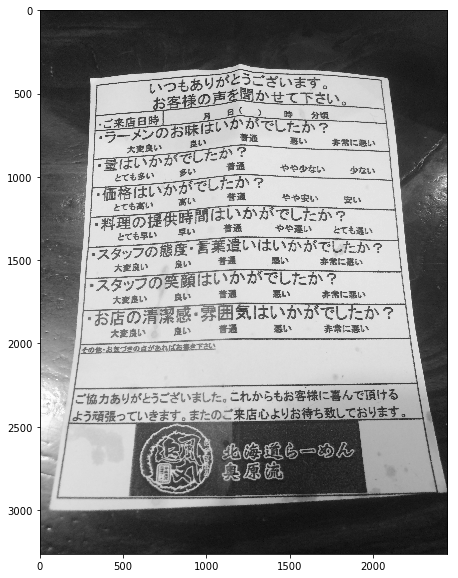

In [97]:
show(gray)

In [98]:
# きれいな線画を取る
kernel = np.ones([5, 5])
dilate = cv2.dilate(gray, kernel, iterations=2)
sub_inv = dilate - gray

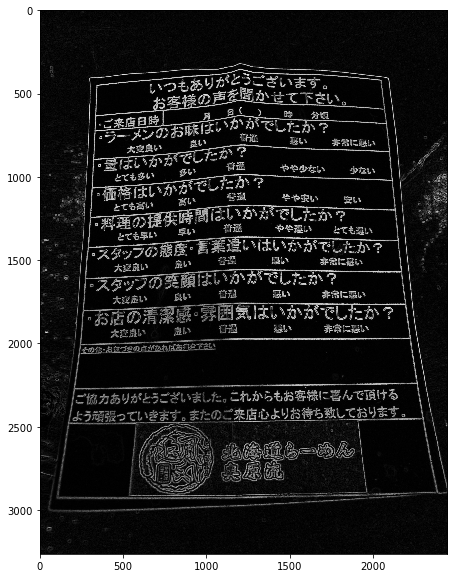

In [99]:
show(sub_inv)

In [100]:
# 平滑化
ga = cv2.GaussianBlur(sub_inv, (11, 11), 0)

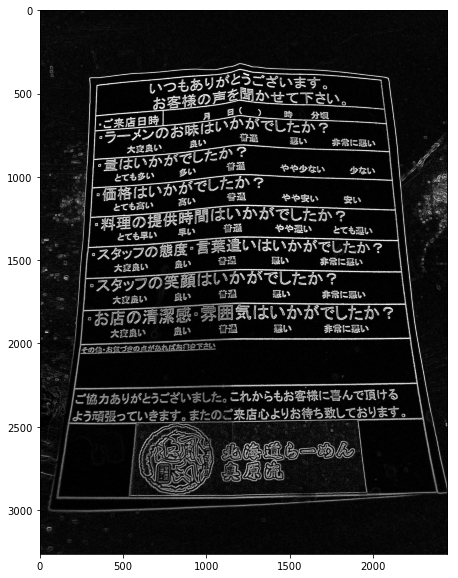

In [101]:
show(ga)

In [102]:
# 二値化
_, th = cv2.threshold(ga, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

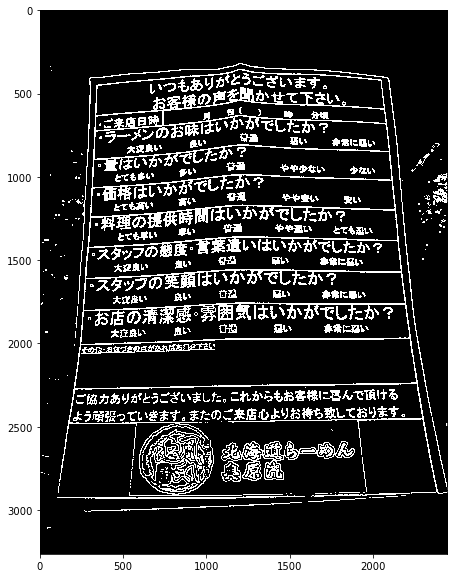

In [103]:
show(th)

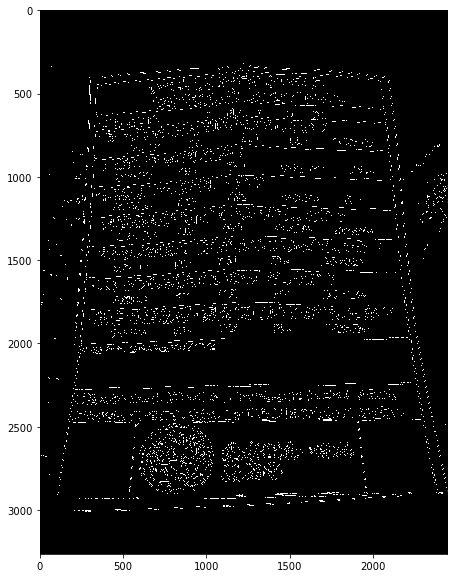

In [104]:
# canny
canny = cv2.Canny(th, 100, 200)
show(canny)

In [105]:
# 輪郭を囲む
_, contours, _ = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

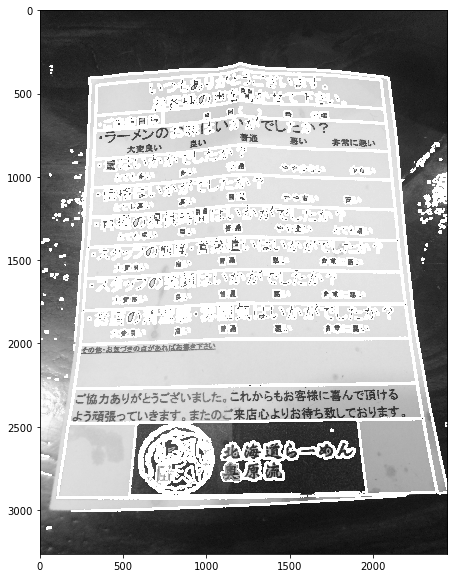

In [106]:
# 確認
draw_img = gray.copy()
drawed_img = cv2.drawContours(draw_img, contours, -1, (255, 255, 255), 10)
show(drawed_img)

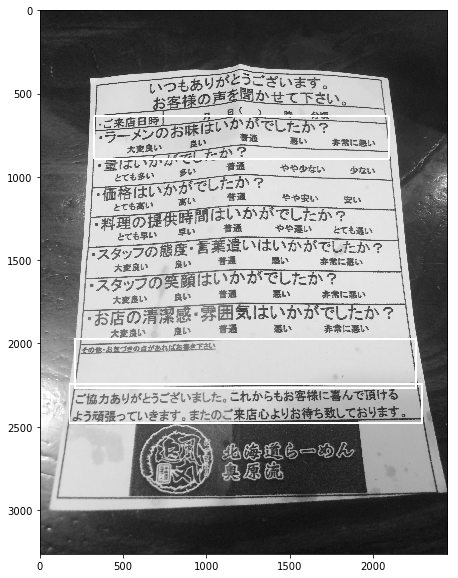

In [107]:
# 四角で囲む
draw_img = gray.copy()
rects = []
for c in contours:
    # 小さい面積の値は使わない
    if cv2.contourArea(c) < 50000: continue
    
    # 四角で囲む
    x, y, w, h = cv2.boundingRect(c)
    draw_img = cv2.rectangle(draw_img, (x, y), (x + w, y + h), (255, 255, 255), 10)
    
    rects.append([x, y, w, h])
show(draw_img)

うまく取れてない

In [108]:
# 改造
rects = []
approxes = []
for c in contours:
    # 小さい面積の値は使わない
    if cv2.contourArea(c) < 1000: continue
    
    arclen = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.0001*arclen, True)    
    if len(approx) < 4:
        continue

    approxes.append(approx)
    
    # 四角で囲む
    x, y, w, h = cv2.boundingRect(c)
    rects.append([x, y, w, h])

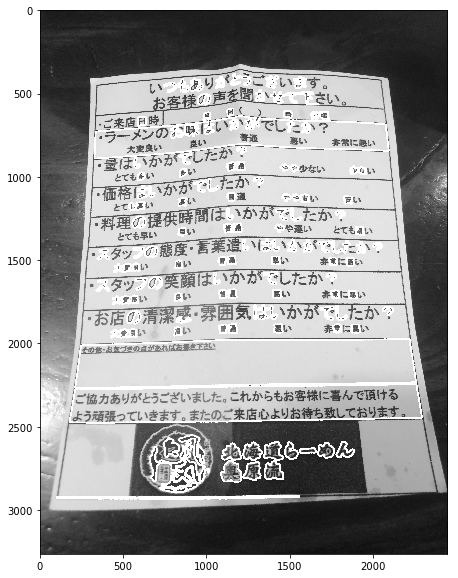

In [109]:
# 確認
draw_img = gray.copy()
drawed_img = cv2.drawContours(draw_img, approxes, -1, (255, 255, 255), 10)
show(drawed_img)

むむむ

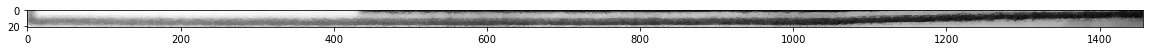

In [110]:
# トリミング
x, y, w, h = rects[0]
trim = gray[y:y+h, x:x+w]
show(trim)

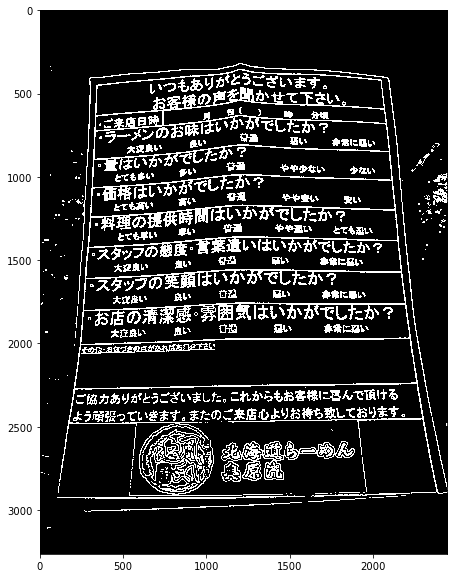

In [117]:
show(th)

In [118]:
cols, rows = th.shape

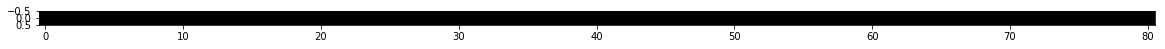

In [162]:
cols_size = cols // 40
cols_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (cols_size, 1))
show(cols_structure)

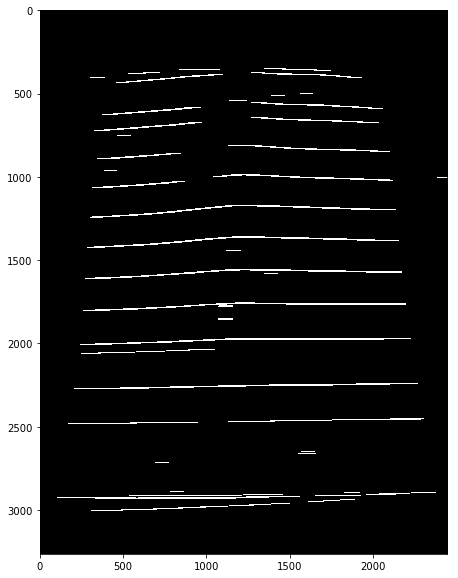

In [163]:
_erode  =cv2.erode(th, cols_structure, (-1, -1))
cols_border = cv2.dilate(_erode, cols_structure, (-1, -1))
show(cols_border)

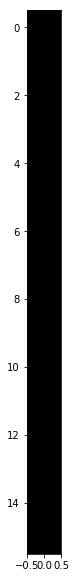

In [164]:
rows_size = cols // 200
rows_structure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, rows_size))
show(rows_structure)

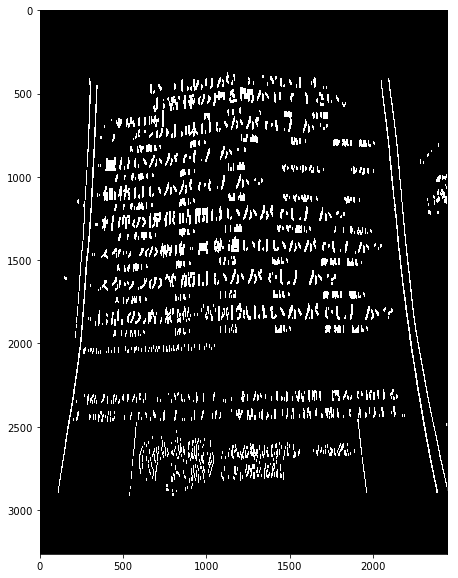

In [165]:
_erode  =cv2.erode(th, rows_structure, (-1, -1))
rows_border = cv2.dilate(_erode, rows_structure, (-1, -1))
show(rows_border)

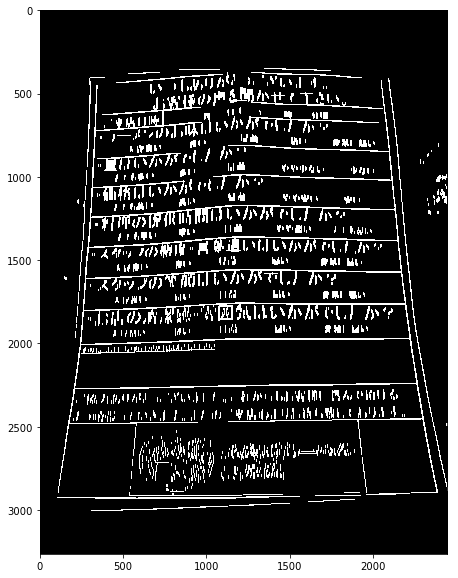

In [166]:
border_mask = rows_border + cols_border
show(border_mask)

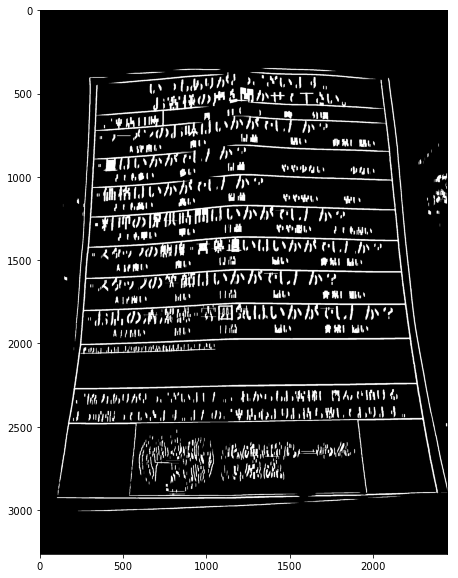

In [176]:
ga_border_mask = cv2.GaussianBlur(border_mask, (11, 11), 0)
show(ga_border_mask)

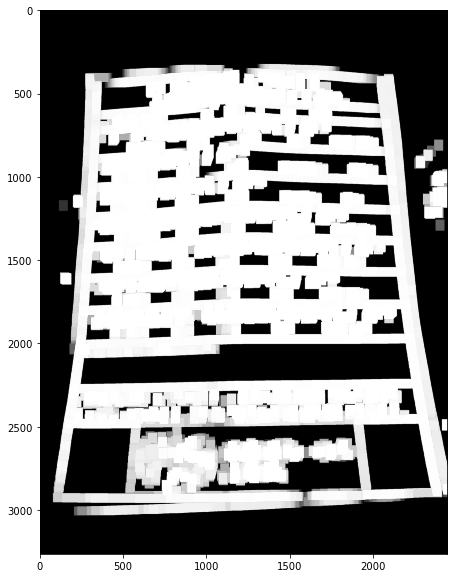

In [185]:
big_kernel = np.ones([50, 50])
big_dilate = cv2.dilate(ga_border_mask, big_kernel, iterations=1)
show(big_dilate)

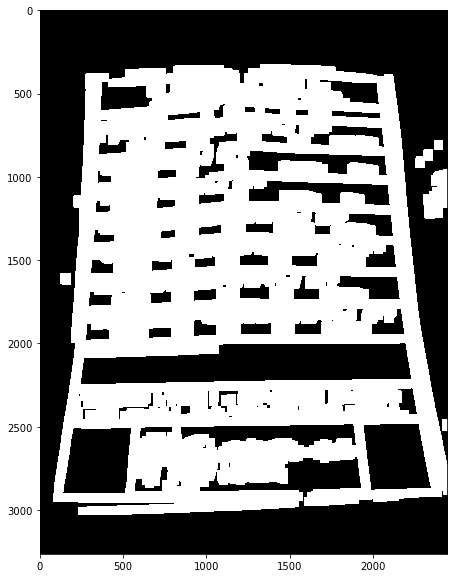

In [186]:
_, th_border_mask = cv2.threshold(big_dilate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
show(th_border_mask)

In [222]:
_, contours, _ = cv2.findContours(th_border_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

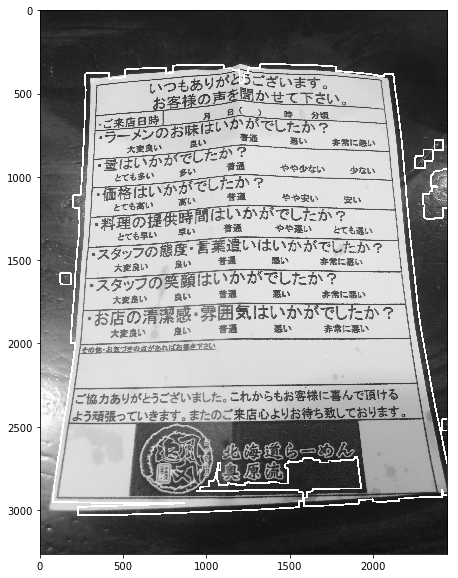

In [223]:
# 確認
draw_img = gray.copy()
drawed_img = cv2.drawContours(draw_img, contours, -1, (255, 255, 255), 10)
show(drawed_img)

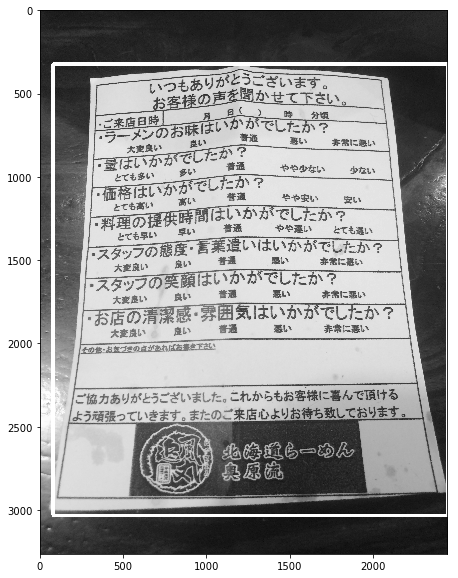

In [232]:
# 改造
rects = []
approxes = []
draw_img = gray.copy()
for c in contours:
    # 小さい面積の値は使わない
    if cv2.contourArea(c) < 50000: continue
    
    arclen = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.001*arclen, True)    
    if len(approx) < 4: continue
    approxes.append(approx)
    
    # 四角で囲む
    x, y, w, h = cv2.boundingRect(c)
    draw_img = cv2.rectangle(draw_img, (x, y), (x + w, y + h), (255, 255, 255), 20)
    rects.append([x, y, w, h])

show(draw_img)

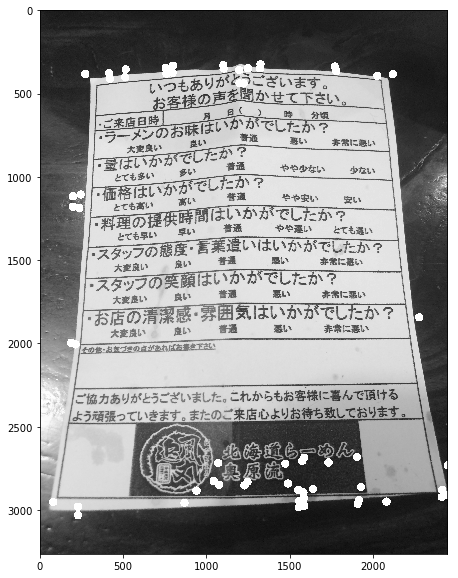

In [233]:
# 確認
draw_img = gray.copy()
drawed_img = cv2.drawContours(draw_img, approxes[-1], -1, (255, 255, 255), 50)
show(drawed_img)

In [236]:
r = approxes[-1].reshape(-1, 2)

In [237]:
# 検出した外枠 四角形の頂点を使い、矩形から4隅の頂点を探す
x, y, w, h = rects[0]
lt = r[np.argmin(np.sum(np.abs(r - (x,     y)),     axis=1))]  # 左上
rt = r[np.argmin(np.sum(np.abs(r - (x + w, y)),     axis=1))]  # 右上
rb = r[np.argmin(np.sum(np.abs(r - (x + w, y + h)), axis=1))]  # 右下
lb = r[np.argmin(np.sum(np.abs(r - (x,     y + h)), axis=1))]  # 左下

In [238]:
transform_rect = np.array([lt, rt, rb, lb], np.float32)

In [239]:
def compute_perspective_transform(img_obj_np, target_vertices_transform):
    (tl, tr, br, bl) = target_vertices_transform

    # 変換後のwidthを決める
    # 上の横幅と下の横幅を計算してどちらが最大かを確認
    width_top = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_bottom = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_top), int(width_bottom))

    # 変換後のheightを決める
    # 計算箇所が代わっただけで、やっていることは横幅と一緒
    height_left = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_right = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_left), int(height_right))

    # 変換後の画像を作成する
    # dst = [左上、右上、右下、左下]
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype='float32')

    # 幾何学変換を行う
    m = cv2.getPerspectiveTransform(target_vertices_transform, dst)
    warped = cv2.warpPerspective(img_obj_np, m, (max_width, max_height))

    return warped

transform_img_obj = compute_perspective_transform(gray, transform_rect)

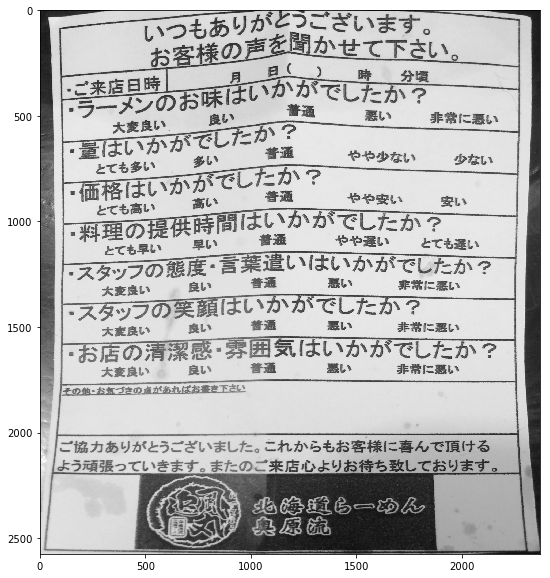

In [240]:
show(transform_img_obj)

In [241]:
from PIL import Image

pillow_obj = Image.fromarray(transform_img_obj)

In [242]:
pillow_obj.save('./test.jpg')

In [243]:
!ls

README.md          __pycache__        config.yml.default test.jpg
Untitled.ipynb     assets             src
